### LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection

Source: https://arxiv.org/pdf/1607.00148.pdf

Interesting Resources:
- https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [ ]:
PLOTS_DIR = '../reports/figures/synthethic_wave_experiments'

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from keras.layers import Dense, LSTM, TimeDistributed, Input, Activation, Dropout
from keras.models import Sequential, Model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
%matplotlib inline

import importlib
import utils
importlib.reload(utils)

def plot_model(model):
    svg_img = model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')
    return SVG(svg_img)

def plot_sample_with_label(data, sample):
    plt.plot(data[0][sample,:,0])
    plt.plot(np.concatenate([[None] * 89, data[0][sample,-1:,0], data[1][sample,:]]), color='r')

def get_mse(data, prediction, sample):
    value = data[1][sample,:]
    prediction = prediction[sample,:]
    return np.sqrt(np.sum((value - prediction) * (value - prediction)))

def plot_sample_with_label_and_prediction(data, prediction, sample, ax=None):
    if ax:
        ax.plot(data[0][sample,:,0])
        ax.plot(np.concatenate([[None] * 89, data[0][sample,-1:,0], data[1][sample,:]]), color='y')
        ax.plot(np.concatenate([[None] * 89, data[0][sample,-1:,0], prediction[sample,:]]), color='r')
        ax.set_title('mse={:.2f}'.format(get_mse(data, prediction, sample)))
        ax.set_xlim((30, 100))
    else:
        plt.plot(data[0][sample,:,0])
        plt.plot(np.concatenate([[None] * 89, data[0][sample,-1:,0], data[1][sample,:]]), color='y')
        plt.plot(np.concatenate([[None] * 89, data[0][sample,-1:,0], prediction[sample,:]]), color='r')
        plt.title('mse={:.2f}'.format(get_mse(data, prediction, sample)))
        plt.xlim((30, 100))

def plot_samples(data, predicted):
    errors = [get_mse(data, predicted, x) for x in range(data[2].shape[0])]
    errors_with_keys = sorted(enumerate(errors), key=lambda x: x[1])
    sorted_samples = [x[0] for x in errors_with_keys]
    fig, axes = plt.subplots(4, 4, figsize=(14, 10))
    for ax, sample in zip(axes.flat, sorted_samples[:4] + sorted_samples[100:104] + sorted_samples[200:204] + sorted_samples[-4:]):
        plot_sample_with_label_and_prediction(data, predicted, sample, ax)
    fig.tight_layout()
    return fig

### Example code for neural-network-based anomaly detection of time-series data (uses LSTM)
Source: https://github.com/aurotripathy/lstm-anomaly-detect/blob/master/lstm-synthetic-wave-anomaly-detect.py

"Inspired by example from
https://github.com/Vict0rSch/deep_learning/tree/master/keras/recurrent
Uses the TensorFlow backend
The basic idea is to detect anomalies in a time-series."

Compilation Time :  0.06316661834716797


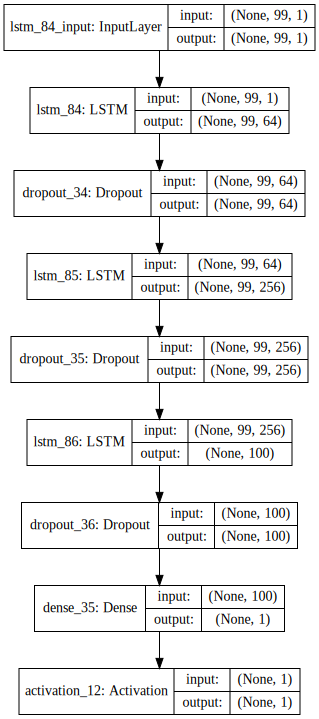

In [102]:
def build_model():
    model = Sequential()
    layers = {'input': 1, 'hidden1': 64, 'hidden2': 256, 'hidden3': 100, 'output': 1}

    model.add(LSTM(
            input_shape=(sequence_length - 1, layers['input']),
            units=layers['hidden1'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden2'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden3'],
            return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=layers['output']))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("Compilation Time : ", time.time() - start)
    return model

model_1 = build_model()
plot_model(model_1)

Compilation Time :  0.042111873626708984

Data Loaded.

Training...
Train on 2612 samples, validate on 138 samples
Epoch 1/1
2612/2612 [==============================] - 42s 16ms/step - loss: 0.1592 - val_loss: 0.0980
Predicting...
Reshaping predicted


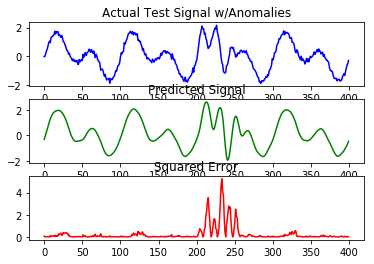

Training duration (s) :  51.18231773376465


In [136]:
model_1, y_test_1, predicted_1 = utils.run_network(
    model=build_model(), data=data, batch_size=batch_size, epochs=epochs)

### Improved model for sequence-to-sequence predection

### Encoder Decoder LSTM

Source: https://arxiv.org/pdf/1607.00148.pdf
-> RebuildInteresting: https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/

Compilation Time :  0.05614972114562988


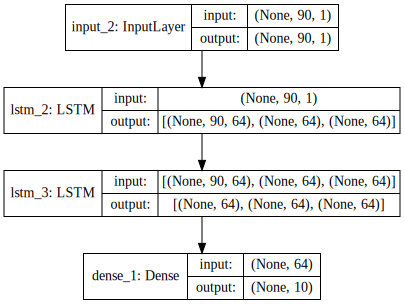

In [6]:
# X shape=(samples, timestamps, features)
# Y shape=(samples,)

# Hyperparameters
sequence_length = 100
num_encoder_tokens = 1 # Only one feature present
num_output_tokens = 10 # Only predict one value # Update: equals prediction_amount
latent_dim = 64 # to avoid "kernel run out of time" situation. I used 256.


# Hyperparameters from paper
L = # length of time-series X (with each datapoint being an m-dimensional vector)
c = # number of LSTM units in encoder

def build_enc_dec_model():
    # sequence_length - 1
    prediction_amount = 10
    encoder_inputs = Input(shape=(sequence_length - prediction_amount, num_encoder_tokens))
    
    encoder = LSTM(latent_dim,
                   batch_input_shape = (1, sequence_length - prediction_amount, num_encoder_tokens),
                   stateful = False,
                   return_sequences = True,
                   return_state = True,
                   recurrent_initializer = 'glorot_uniform')
    # state_h: "hidden state output for the last time step"
    # state_c: "cell state for the last input time step"
    encoder_outputs, state_h, state_c = encoder(encoder_inputs) # 'encoder_outputs' are ignored and only states are kept.
    encoder_states = [state_h, state_c]

    # Decoder training, using 'encoder_states' as initial state.
    # decoder_inputs = Input(shape=(None, num_encoder_tokens))

    decoder_lstm = LSTM(latent_dim,
                        batch_input_shape = (1, sequence_length - prediction_amount, num_encoder_tokens),
                        stateful = False,
                        return_sequences = False,
                        return_state = True,
                        dropout = 0.2,
                        recurrent_dropout = 0.2)

    # decoder_output: "hidden state for each input time step"
    decoder_outputs, _, _ = decoder_lstm(encoder_outputs, initial_state = encoder_states)
    # Suites only for reconstruction, not prediction (and not for negative values):
    # -> decoder_dense = TimeDistributed(Dense(num_output_tokens, activation = 'relu'))
    decoder_dense = Dense(num_output_tokens)
    decoder_outputs = decoder_dense(decoder_outputs)

    # training model
    training_model = Model([encoder_inputs], decoder_outputs)
    start = time.time()
    training_model.compile(optimizer = 'adam', loss = 'mse')
    print("Compilation Time : ", time.time() - start)
    return training_model

model_2 = build_enc_dec_model()
plot_model(model_2)

In [4]:
np.random.seed(1234)

# Global hyper-parameters
sequence_length = 100
epochs = 50
batch_size = 50

data = utils.get_split_prep_data(0, 700, 500, 1000, sequence_length)

wave1 1000
wave2 1000
wave3 50
Length of Data 1000
Creating train data...
Mean of train data :  0.0017174984265156412
Train data shape  :  (600, 100)
X shape: (600, 90)
y shape: (600, 10)
Creating test data...
Mean of test data :  0.01647475124693149
Test data shape  :  (400, 100)
Shape X_train (2750, 90)
Shape X_test (400, 90)


### Visualization

In [114]:
data = utils.get_split_prep_data(0, 700, 500, 1000, sequence_length)

wave1 1000
wave2 1000
wave3 50
Length of Data 1000
Creating train data...
Mean of train data :  0.007358448765511458
Train data shape  :  (600, 100)
X shape: (300, 90)
y shape: (300, 10)
Creating test data...
Mean of test data :  -0.002577488258638369
Test data shape  :  (400, 100)
Shape X_train (1363, 90)
Shape X_test (400, 90)



Data Loaded.

Training...
Train on 1294 samples, validate on 69 samples
Epoch 1/50
1294/1294 [==============================] - 3s 2ms/step - loss: 0.0915 - val_loss: 0.1322
Epoch 2/50
1294/1294 [==============================] - 3s 2ms/step - loss: 0.0770 - val_loss: 0.1169
Epoch 3/50
1294/1294 [==============================] - 3s 2ms/step - loss: 0.0682 - val_loss: 0.0957
Epoch 4/50
1294/1294 [==============================] - 3s 2ms/step - loss: 0.0605 - val_loss: 0.0845
Epoch 5/50
1294/1294 [==============================] - 4s 3ms/step - loss: 0.0544 - val_loss: 0.0830
Epoch 6/50
1294/1294 [==============================] - 4s 3ms/step - loss: 0.0461 - val_loss: 0.0715
Epoch 7/50
1294/1294 [==============================] - 4s 3ms/step - loss: 0.0382 - val_loss: 0.0542
Epoch 8/50
1294/1294 [==============================] - 4s 3ms/step - loss: 0.0291 - val_loss: 0.0366
Epoch 9/50
1294/1294 [==============================] - 3s 3ms/step - loss: 0.0242 - val_loss: 0.0322
Epoch 10/

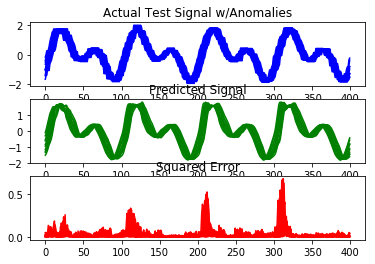

Training duration (s) :  153.08416152000427


In [115]:
model_2, y_test_2, predicted_2 = utils.run_network(model=model_2, data=data, batch_size=batch_size, epochs=epochs)

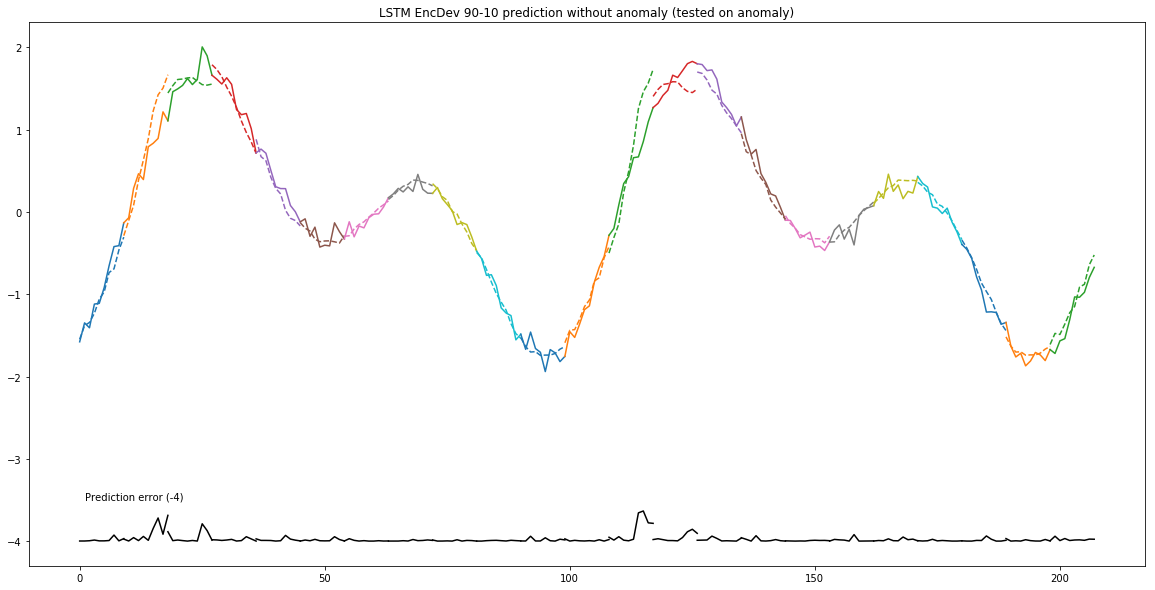

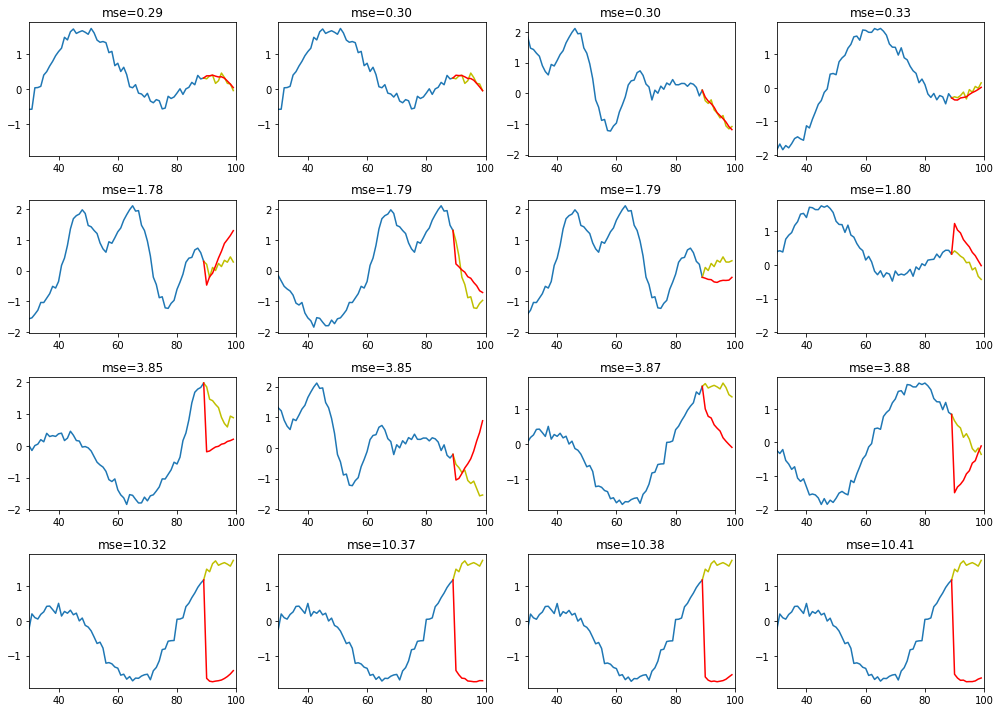

In [117]:
def plot_test_with_prediction(y_test, predicted, from_=0, to_=-1):
    size = y_test.shape[1] - 1
    steps = 0
    plt.figure(figsize=(20, 10))
    for frame, pred_frame in zip(y_test[from_:to_:size], predicted[from_:to_:size]):
        line = plt.plot(np.concatenate([[None]*steps, frame]))
        plt.plot(np.concatenate([[None]*steps, pred_frame]), color=line[0].get_color(), linestyle='--')
        mse = np.abs((frame - pred_frame) * (frame - pred_frame))
        plt.plot(np.concatenate([[None]*steps, mse - 4]), 'black')
        steps += size
    plt.title('LSTM EncDev 90-10 prediction on anomaly')
    plt.text(1, -3.5, 'Prediction error (-4)')
    plt.savefig(os.path.join(PLOTS_DIR, 'LSTM-EncDec-Prediction-{}.pdf'.format(int(time.time()))))

# First run -> loss: 0.0110 - val_loss: 0.0113
# Sec run -> loss: 0.0099 - val_loss: 0.0118
# loss: 0.0096 - val_loss: 0.0105
plot_test_with_prediction(y_test_2, predicted_2, 100, 300)
plot_samples(data, predicted_2)
plt.savefig(os.path.join(PLOTS_DIR, 'LSTM-EncDec-Samples-{}.pdf'.format(int(time.time()))))

### Inspect ECG data

(10000, 3)


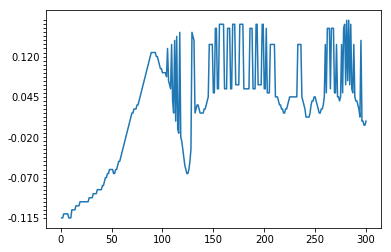

In [126]:
# Source: https://www.physionet.org/cgi-bin/atm/ATM
# Remove single quote from column names, remove first row (Einheiten)
ecg = pd.read_csv('data/ecg_p1_s1_samples.csv').rename(columns=lambda x: x[1:-1]).drop(0)
print(ecg.shape)
ecg.head()
fig, ax = plt.subplots()
ax.plot(ecg["ECG I filtered"][:300])
# plt.locator_params(axis='y', nbins=6)
every_nth = 10
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
# print(plt.yticks()[0])
# plt.yticks(np.linspace(int(plt.yticks()[0][0]), int(plt.yticks()[0][-1]), 10))